In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libs
import numpy as np
import glob
#from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
from utils import get_model, set_seed
#from denoise_traditional import denoise_gaussian, denoise_nlm

#from monai.transforms import Compose, RandFlip, RandRotate, RandGaussianNoise, RandAdjustContrast, ScaleIntensity

from unet import UNet
from PIL import Image

from train import train_seg

import os
import logging
import time

In [3]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available! Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
# device = torch.device("cpu")
print(device)

CUDA is available! Training on GPU.
cuda


In [4]:
device = torch.device("cpu")

In [5]:
#IMPORT DATA:
TRAINING_DATA_PATH = "/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/google_colab/labeled_mri_gray"

IMAGE_PATHS = glob.glob("/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/google_colab/labeled_mri_gray/*_post.png")
MASK_PATHS = [f.replace("_post.png", "_subtraction_label.png") for f in IMAGE_PATHS]

split_idx = int(0.8 * len(IMAGE_PATHS)) # 80% training, 20% testing

TRAINING_IMAGE_PATHS = IMAGE_PATHS[:split_idx]
TESTING_IMAGE_PATHS = IMAGE_PATHS[split_idx:]

TRAINING_MASK_PATHS = MASK_PATHS[:split_idx]
TESTING_MASK_PATHS = MASK_PATHS[split_idx:]
print(IMAGE_PATHS)
print(MASK_PATHS)
print(len(TRAINING_IMAGE_PATHS))

['/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/google_colab/labeled_mri_gray/slice_0608_post.png', '/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/google_colab/labeled_mri_gray/slice_1188_post.png', '/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/google_colab/labeled_mri_gray/slice_0650_post.png', '/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/google_colab/labeled_mri_gray/slice_0809_post.png', '/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/google_colab/labeled_mri_gray/slice_1255_post.png', '/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/google_colab/labeled_mri_gray/slice_1066_post.png', '/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/google_colab/labeled_mri_gray/slice_0690_post.png', '/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/google_colab/labeled_mri_gray/slice_1167_post.png', '/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/google_colab/labeled_mri_gray/slic

In [6]:
class segmentationDataSet(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform 

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")  # Implement your image loading
        
        image = np.array(image) / 255.0  # Normalize to [0, 1] here!        # Convert to PyTorch tensor and permute dimensions
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # [C, H, W]
        #mask = Image.open(self.image_paths[idx])
        #MASK MIGHT BE ISSUE
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))
        mask = (mask > 0).astype(np.int64)  # Convert 255 → 1, keep 0 as 0
        mask = np.expand_dims(mask, axis=0)  # Shape: [1, H, W]
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask
    


In [7]:
breast_data_train = segmentationDataSet(TRAINING_IMAGE_PATHS, TRAINING_MASK_PATHS)
breast_data_test = segmentationDataSet(TESTING_IMAGE_PATHS, TESTING_MASK_PATHS)

trainloader = utils.DataLoader(breast_data_train,
                                batch_size = 4, 
                                shuffle = False,
                                num_workers = 0,
                                drop_last = True)

testloader = utils.DataLoader(breast_data_test,
                                batch_size = 4, 
                                shuffle = False,
                                num_workers = 0,
                                drop_last = True)


In [8]:
sample = trainloader.dataset[0]  # Get first sample
print(type(sample))  # Check what type it is
#print(len(sample))  # Check if it's a tuple/list and how many elements

<class 'tuple'>


In [9]:
testimg, testlabel = next(iter(trainloader))

print(testimg.shape)
print(testlabel.shape)


torch.Size([4, 3, 300, 300])
torch.Size([4, 1, 300, 300])


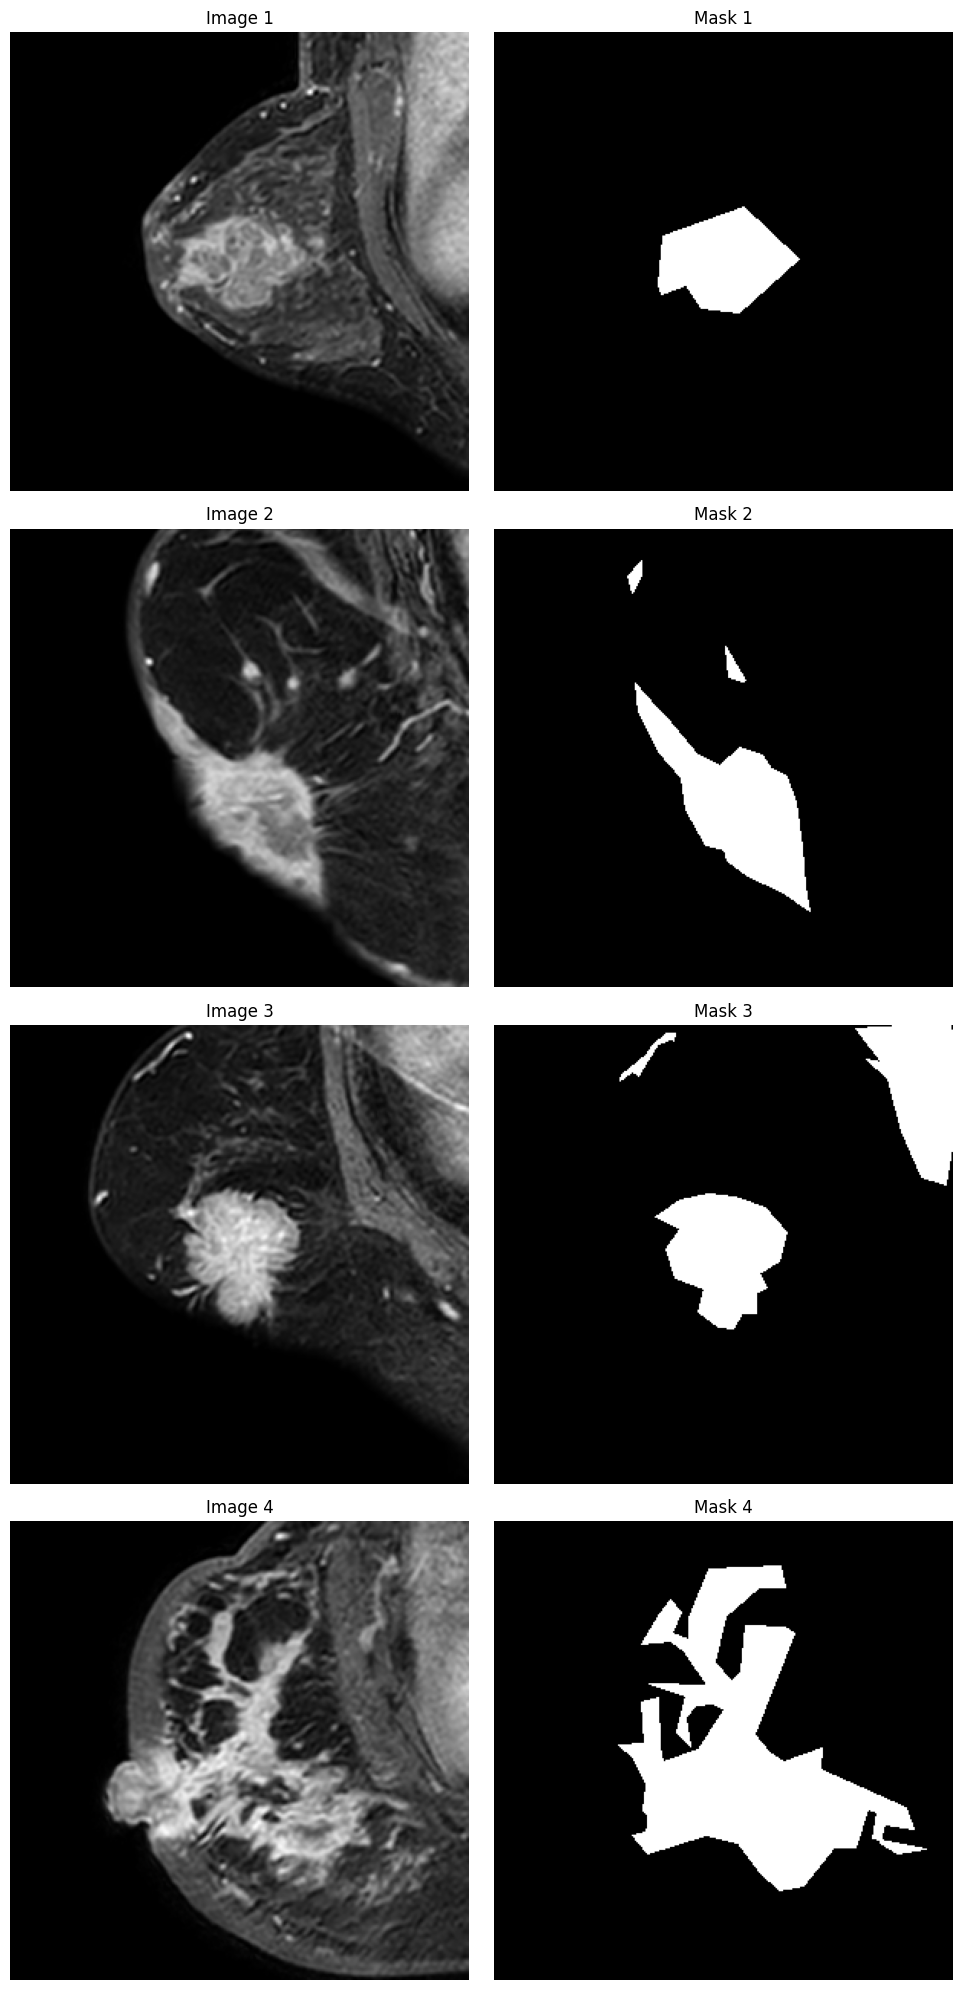

In [10]:
# Get a batch of data
images, masks = next(iter(trainloader))

# Convert tensors to numpy arrays and denormalize if needed
images = images.numpy().transpose(0, 2, 3, 1)  # [B, C, H, W] → [B, H, W, C] for plotting
masks = masks.numpy().squeeze(1)  # [B, 1, H, W] → [B, H, W] (remove channel dim)

# Plot first 4 samples in the batch
fig, axes = plt.subplots(4, 2, figsize=(10, 20))  # 4 rows, 2 columns (image + mask)

for i in range(4):
    # Plot image
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis("off")

    # Plot mask (binary or grayscale)
    axes[i, 1].imshow(masks[i], cmap="gray")  # Use 'gray' colormap for masks
    axes[i, 1].set_title(f"Mask {i+1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [11]:
# Initialize model
model = UNet(in_channels=3, out_channels=1, init_features=64)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid and binary cross-entropy
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)



LOAD MODEL:

In [12]:
model = torch.load("/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/Model/first_trained_model.pth", weights_only=False ,map_location=torch.device('cpu'))

Output shape: torch.Size([4, 1, 300, 300])
Output min/max: tensor(0.0065) tensor(1.)
Output sample: tensor([[[0.0395, 0.0222, 0.0190],
         [0.0194, 0.0184, 0.0193],
         [0.0184, 0.0161, 0.0189]]])


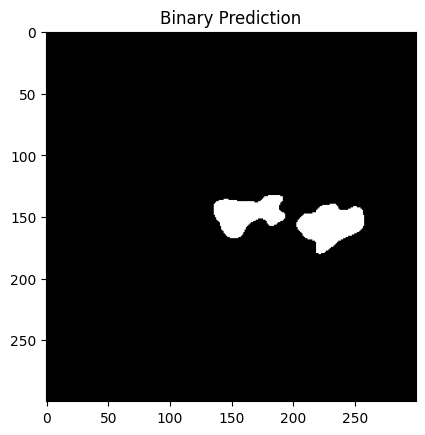

In [13]:
img, label = next(iter(testloader))
img = img.float().to(device)

model.eval()  # Set to evaluation mode
with torch.no_grad():
    output = model(img)  # Raw model output

print("Output shape:", output.shape)
print("Output min/max:", output.min(), output.max())
print("Output sample:", output[0, :3, :3, :3])  # First image, first 3 classes, 3x3 pixels

threshold = 0.5
binary_pred = (output > threshold).float()  # Shape: [4, 1, 300, 300]

# Visualize
pred_mask = binary_pred[0, 0].cpu().numpy()  # Shape: [300, 300]
plt.imshow(pred_mask, cmap='gray')
plt.title("Binary Prediction")
plt.show()

In [14]:
data_iter = iter(testloader)

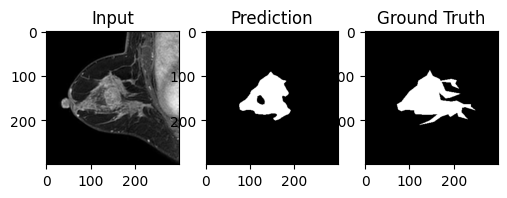

In [20]:
model.eval()
img, label = next(data_iter)  # Gets the next batch (different each run)
with torch.no_grad():
    output = model(img.float().to(device))

# Binary thresholding
pred_mask = (output > 0.5).float()

# Select first image in batch
img_vis = img[0].cpu().permute(1, 2, 0)  # CHW → HWC for plotting
pred_vis = pred_mask[0, 0].cpu().numpy()  # Shape: [300, 300]
label_vis = label[0].squeeze(0).cpu().numpy()

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 6, 1)
plt.imshow(img_vis)
plt.title("Input")
plt.subplot(1, 6, 2)
plt.imshow(pred_vis, cmap='gray')
plt.title("Prediction")
plt.subplot(1, 6, 3)
plt.imshow(label_vis, cmap='gray')
plt.title("Ground Truth")
plt.show()

In [17]:
torch.save(model.state_dict(), 'model_weightsa.pth')

In [18]:
# vali

checkpoint = torch.load('model_weights_8_21_34_50_l2_1e-3.pth')
net.load_state_dict(checkpoint)
net.eval()

breast_data_inf = BreastDataset_seg(time_point,train_file_dir,train_val="inf",one_or_twoDim=False,denoise=if_denoise, seg_num=seg_parts)


infloader = utils.DataLoader(breast_data_inf ,
                                batch_size = 1, 
                                shuffle = False,
                                num_workers = 0,
                                drop_last = False)

FileNotFoundError: [Errno 2] No such file or directory: 'model_weights_8_21_34_50_l2_1e-3.pth'